In [ ]:
!pip install torch torchvision

In [ ]:
!pip install scikit-learn

In [ ]:
!pip install tqdm

In [ ]:
!pip install pandas

In [1]:
import torch
import torch.nn as nn
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image
from PIL import Image
import os
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


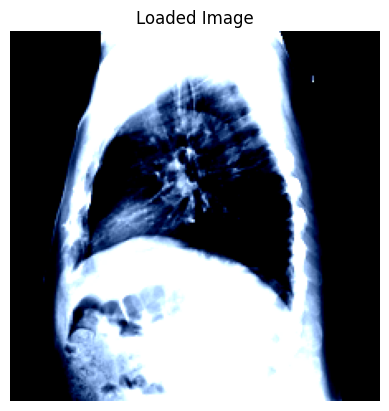

In [11]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Load the tensor
image_tensor = torch.load("input_images/solution_lateral/3039.pt")  # shape might be [1, H, W] or [C, H, W]

# Convert to NumPy and transpose to HWC
image_np = image_tensor.cpu().numpy()
image_np = np.transpose(image_np, (1, 2, 0))  # CHW -> HWC

# Optional: Unnormalize (if you normalized with mean/std before training)
# image_np = image_np * 0.5 + 0.5  # for mean=0.5, std=0.5 normalization

# Clip to [0,1] if needed for display
image_np = np.clip(image_np, 0, 1)

# Display
plt.imshow(image_np)
plt.axis('off')
plt.title("Loaded Image")
plt.show()

# CHANGE THIS

In [3]:
##MAKE SURE TO CHANGE THIS
#best_model_path = "models/fr_split_model.pth"
target_col = 'Enlarged Cardiomediastinum'

In [3]:
class CSVDataset(Dataset):
    def __init__(self, dataframe, image_root_dir, target_columns=None, transform=None,
                 save_dir=None, use_saved_images=False):
        self.data = dataframe
        self.image_root_dir = image_root_dir
        self.target_columns = target_columns
        self.transform = transform
        self.save_dir = save_dir
        self.use_saved_images = use_saved_images

        if self.save_dir:
            os.makedirs(self.save_dir, exist_ok=True)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        
        # Use index for the saved tensor filename
        image_index = row['Unnamed: 0']
        saved_image_path = os.path.join(self.save_dir, f"{image_index}.pt")

        if self.use_saved_images:
            if os.path.exists(saved_image_path):
                image_tensor = torch.load(saved_image_path)
            else:
                raise FileNotFoundError(f"Saved tensor not found: {saved_image_path}")
        else:
            original_image_path = os.path.join(self.image_root_dir, row['Path'])
            image = Image.open(original_image_path).convert("L")
            image_tensor = self.transform(image) if self.transform else transforms.ToTensor()(image)

            if self.save_dir:
                torch.save(image_tensor, saved_image_path)

        if self.target_columns:
            labels = pd.to_numeric(row[self.target_columns], errors='coerce').fillna(0).astype(float).values
            labels = torch.tensor(labels, dtype=torch.float32)
            return image_tensor, labels

        return image_tensor

In [4]:
class MultiLabelResNet50(nn.Module):
    def __init__(self, num_classes, hidden_size = 512, dropout_rate=0.5):
        super(MultiLabelResNet50, self).__init__()
        
        # Load pre-trained ResNet50
        self.base_model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        
        # Modify the fully connected layer for multi-label classification
        self.base_model.fc = nn.Sequential(
            nn.Linear(self.base_model.fc.in_features, hidden_size),  # New intermediate layer. ##512 --> 256
            nn.ReLU(),
            nn.Dropout(dropout_rate),  # Dropout to prevent overfitting ##0.5 --> 0.6
            nn.Linear(hidden_size, num_classes),  # Output layer
            nn.Sigmoid()  # Sigmoid for multi-label classification (soften the data)
            #nn.Tanh()  #This is between -1 and 1

           # nn.Linear(self.base_model.fc.in_features, num_classes),
           # nn.Sigmoid()  # Sigmoid activation for multi-label classification
        )

    def forward(self, x):
        return self.base_model(x)

In [6]:
class MultiLabelResNet50_2(nn.Module):
    def __init__(self, num_classes):
        super(MultiLabelResNet50_2, self).__init__()
        
        # Load pre-trained ResNet50
        self.base_model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        
        # Modify the fully connected layer for multi-label classification
        self.base_model.fc = nn.Sequential(
            nn.Linear(self.base_model.fc.in_features, 256),  # New intermediate layer. ##512 --> 256
            nn.ReLU(),
            nn.Dropout(0.6),  # Dropout to prevent overfitting ##0.5 --> 0.6
            nn.Linear(256, num_classes),  # Output layer
            nn.Sigmoid()  # Sigmoid for multi-label classification (soften the data)
            #nn.Tanh()  #This is between -1 and 1

           # nn.Linear(self.base_model.fc.in_features, num_classes),
           # nn.Sigmoid()  # Sigmoid activation for multi-label classification
        )

    def forward(self, x):
        return self.base_model(x)

In [7]:
class NoFindingRefiner(nn.Module):
    def __init__(self, input_dim=6):  # 1 from image model + 5 pathology scores
        super(NoFindingRefiner, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            #nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.5), #was 0.5
            nn.Linear(64, 1),
            nn.Sigmoid()  # Because your scores range from 0 to 1
        )

    def forward(self, x):
        return self.model(x).squeeze(1)


In [8]:
class NoFindingRefiner2(nn.Module):
    def __init__(self, input_dim=6):  # 1 from image model + 5 pathology scores
        super(NoFindingRefiner2, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            #nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.5),  #0.3 for 3
            nn.Linear(128, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.3),  #0.3 for 3
            nn.Linear(32, 1),
            nn.Sigmoid()  # Because your scores range from 0 to 1
        )

    def forward(self, x):
        return self.model(x).squeeze(1)


In [9]:
class MultiLabelDenseNet121(nn.Module):
    def __init__(self, num_classes, hidden_dim = 512, dropout_rate=0.5):
        super(MultiLabelDenseNet121, self).__init__()

        # Load pre-trained DenseNet-121
        self.base_model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
        
        # Replace the classifier with a custom head
        self.base_model.classifier = nn.Sequential(
            nn.Linear(self.base_model.classifier.in_features, hidden_dim),  
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, num_classes),
            nn.Tanh()  # Output values in [-1, 1] for each class
        )

    def forward(self, x):
        return self.base_model(x)

In [10]:
image_root = '/central/groups/CS156b/2025/CodeMonkeys/input_images'
image_root_dir = "input_images/train_saved_tensors"
train_save_dir = os.path.join(image_root, 'train_saved_tensors')

def get_filtered_df(col, num=None):
    
    #test_save_dir = os.path.join(image_root, 'test')
    full_train_df = pd.read_csv('train2023.csv')
    #print(len(full_train_df))
    #filtered_train_df = full_train_df.iloc[:29692]
    if num != None:
        full_train_df = full_train_df.iloc[:num]

    filtered_train_df = full_train_df.dropna(subset=[col]).copy()
    filtered_train_df[col] = (filtered_train_df[col] + 1) / 2

    df_front = filtered_train_df[filtered_train_df['Frontal/Lateral'] == 'Frontal'].copy()
    df_lat = filtered_train_df[filtered_train_df['Frontal/Lateral'] == 'Lateral'].copy()

    #filtered_train_df = filtered_train_df[filtered_train_df[col] != 0.5]  # Drop rows with 'Pleural_Effusion' == 0
    return df_lat, df_front

train_df_lat, train_df_front = get_filtered_df(target_col)
#print(len(filtered_train_df))

NameError: name 'target_col' is not defined

# LATERAL VS FRONTAL

In [24]:
##CHANGE THIS IF U WANT LAT VS FRONTAL
best_model_path = "models/ec_lat_model.pth"
filtered_train_df = train_df_lat

In [23]:
##DONT GENERALLY WANT THIS
# # Define desired number of samples per class
sample_sizes = {
    0.0: 10000,
    0.5: 6000,
    1.0: 10000
}

dfs = []
for label, n_samples in sample_sizes.items():
    class_df = filtered_train_df[filtered_train_df[target_col] == label]
    # Sample with replacement if not enough data
    sampled_df = class_df.sample(n=n_samples, replace=(n_samples > len(class_df)), random_state=42)
    dfs.append(sampled_df)

# Combine and shuffle
balanced_df = pd.concat(dfs).sample(frac=1, random_state=42).reset_index(drop=True)
filtered_train_df = balanced_df


In [25]:
label_counts = filtered_train_df[target_col].value_counts()
print(label_counts)

Enlarged Cardiomediastinum
0.0    5255
0.5    2141
1.0    1124
Name: count, dtype: int64


In [ ]:
##DONT GENERALLY WANT THIS -- undersampling
label_counts = filtered_train_df[target_col].value_counts()

# Get majority class (should be 1.0)
majority_class = label_counts.idxmax()

# Separate the majority and minority classes
majority_df = filtered_train_df[filtered_train_df[target_col] == majority_class]
minority_df = filtered_train_df[filtered_train_df[target_col] != majority_class]

# Randomly sample 10,000 from the majority class
majority_sampled_df = majority_df.sample(n=10000, random_state=42)

# Combine back
balanced_df = pd.concat([majority_sampled_df, minority_df]).sample(frac=1, random_state=42).reset_index(drop=True)
filtered_train_df = balanced_df

In [26]:
from sklearn.model_selection import train_test_split

# Define your target columns once
target_columns = [target_col]

# Step 1: Split the dataframe
train_df, val_df = train_test_split(filtered_train_df, test_size=0.15, random_state=42)

##MAY WANT TO GET RID OF THESE
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

# Step 2: Create training dataset
train_dataset = CSVDataset(
    dataframe=train_df, 
    image_root_dir=image_root, 
    target_columns=target_columns, 
    save_dir=train_save_dir, 
    use_saved_images=True
)

# Step 3: Create validation dataset
val_dataset = CSVDataset(
    dataframe=val_df, 
    image_root_dir=image_root, 
    target_columns=target_columns, 
    save_dir=train_save_dir, 
    use_saved_images=True
)

# Step 4: Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True) ##64 --> 32 --> 16 (prev)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [27]:
##This is for oversampling
fracture_labels = train_df[target_col].values
label_map = {0.0: 0, 0.5: 1, 1.0: 2}
mapped_labels = np.array([label_map[float(lbl)] for lbl in fracture_labels])

class_counts = np.bincount(mapped_labels)
weights = 1. / (class_counts + 1e-6)
sample_weights = torch.tensor(weights[mapped_labels], dtype=torch.float)

sampler = torch.utils.data.WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)
train_loader = DataLoader(train_dataset, batch_size=16, sampler=sampler)

In [17]:
def freeze_base_layers_dn(model):
    """
    Freeze initial layers of DenseNet-121 up to denseblock3.
    """
    freeze = True
    for name, child in model.base_model.features.named_children():
        if name == 'denseblock2':
            freeze = False
        if freeze:
            for param in child.parameters():
                param.requires_grad = False
    return model

In [18]:
def freeze_base_layers(model, until_layer=6):
    """
    Freeze layers of ResNet-50 up to a certain stage (e.g., until_layer=6 means keep layers 0-5 frozen).
    """
    child_counter = 0
    for child in model.base_model.children():
        if child_counter < until_layer:
            for param in child.parameters():
                param.requires_grad = False
        child_counter += 1
    return model


In [28]:
uncertain_weight_factor = 0.25
class_weights = {}

# Loop over each target column
for col in target_columns:
    # Count the occurrences of each class in the column
    counts = filtered_train_df[col].value_counts()
    total = len(filtered_train_df[col])
    
    # Calculate class weights using inverse frequency (you can also experiment with other strategies)
    weights = {
        0: total / (counts.get(0, 0) + 1),  # Add 1 to avoid division by zero
        0.5: total / (counts.get(0.5, 0) + 1) * uncertain_weight_factor,
        1: total / (counts.get(1, 0) + 1)
    }
    
    # Store weights for each class
    class_weights[col] = weights
class_weights[target_col] = {0: 1.0, 0.5: 0.6, 1: 1.0}  ##GET RID OF THIS LINE IF DONT HAVE SAMPLER -- also 0.5
# Example: Print out the weights for each class
for col in target_columns:
    print(f"Class weights for {col}: {class_weights[col]}")


Class weights for Enlarged Cardiomediastinum: {0: 1.0, 0.5: 0.6, 1: 1.0}


In [29]:
criterion = nn.MSELoss(reduction='none')

def masked_MSE_loss(output, target, class_weights):
    # Compute element-wise MSE
    loss = criterion(output, target)  # shape: [batch_size, 1]

    # Get weights per target value (assume target values are 0.0, 0.5, or 1.0)
    weights = torch.tensor([class_weights.get(float(val.item()), 1.0) for val in target.squeeze()],
                           dtype=torch.float32,
                           device=output.device).unsqueeze(1)  # shape: [batch_size, 1]

    # Apply weights to loss
    weighted_loss = loss * weights

    return weighted_loss.mean()

'''def masked_MSE_loss(output, target, class_weights):
    # Create a mask for non-NaN target values
    mask = ~torch.isnan(target)
    
    # Apply the MSE loss
    loss = criterion(output, target)
    
    # Loop through each class and apply the class weights
    for class_idx, col in enumerate(target_columns):
        # Get the class values for the current class
        class_values = target[:, class_idx]
        
        # Apply the class weights to each class value
        weight = torch.tensor([class_weights[col].get(x.item(), 1) for x in class_values], dtype=torch.float32, device=output.device)
        
        # Apply the weight to the loss (broadcast the weight to match the loss shape)
        loss = loss * mask  # Apply mask to exclude NaN targets
        loss[:, class_idx] *= weight  # Apply weight per class
    
    # Return mean loss for valid entries
    return loss.sum() / mask.sum()'''


'def masked_MSE_loss(output, target, class_weights):\n    # Create a mask for non-NaN target values\n    mask = ~torch.isnan(target)\n    \n    # Apply the MSE loss\n    loss = criterion(output, target)\n    \n    # Loop through each class and apply the class weights\n    for class_idx, col in enumerate(target_columns):\n        # Get the class values for the current class\n        class_values = target[:, class_idx]\n        \n        # Apply the class weights to each class value\n        weight = torch.tensor([class_weights[col].get(x.item(), 1) for x in class_values], dtype=torch.float32, device=output.device)\n        \n        # Apply the weight to the loss (broadcast the weight to match the loss shape)\n        loss = loss * mask  # Apply mask to exclude NaN targets\n        loss[:, class_idx] *= weight  # Apply weight per class\n    \n    # Return mean loss for valid entries\n    return loss.sum() / mask.sum()'

## No Grid Search

In [ ]:
##NEW VERSION FOR FRACTURE
import numpy as np
import torch
import torch.optim as optim
import os

best_model_path = "models/fr_front_model10.pth"  ##Then get rid of this

# Hyperparameters and model setup
num_classes = 1  # Predicting 'Pleural Effusion'
model = MultiLabelResNet50_2(num_classes=num_classes).to(device)
model = freeze_base_layers(model, until_layer=2)  # Freeze layers
optimizer = optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-4)

# Early stopping parameters
early_stopping_patience = 3
best_val_loss = float('inf')
patience_counter = 0
os.makedirs("models", exist_ok=True)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1)

num_epochs = 15
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = masked_MSE_loss(outputs, labels, class_weights)
        running_loss += loss.item()

        loss.backward()
        optimizer.step()

        predicted_class = torch.where(outputs > 0.5, torch.tensor(1.0).to(device),
                                      torch.where(outputs < -0.5, torch.tensor(-1.0).to(device), torch.tensor(0.0).to(device)))
        correct += (predicted_class == labels).sum().item()
        total += labels.numel()

    avg_loss = running_loss / len(train_loader)
    accuracy = correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = masked_MSE_loss(outputs, labels, class_weights)
            val_loss += loss.item()

            predicted_class = torch.where(
                outputs < 0.25, torch.tensor(0.0).to(device),
                torch.where(
                    outputs < 0.75, torch.tensor(0.5).to(device),
                    torch.tensor(1.0).to(device)
                )
            )

            all_preds.append(predicted_class.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

            val_correct += (predicted_class == labels).sum().item()
            val_total += labels.numel()

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = val_correct / val_total

    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    scheduler.step(avg_val_loss)

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), best_model_path)
        #print("✅ Saved new best model.")
    else:
        patience_counter += 1
     #   print(f"⏳ No improvement. Patience: {patience_counter}/{early_stopping_patience}")

    # Stop if patience exceeded
    if patience_counter >= early_stopping_patience:
        print("⛔ Early stopping triggered.")
        break

In [16]:
print(f"Dataset length: {len(train_dataset)}")
print(f"Sampler length: {len(sampler)}")



Dataset length: 11050


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f41a043b5e0>>
Traceback (most recent call last):
  File "/home/abaxter/.local/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


NameError: name 'sampler' is not defined

In [31]:
import numpy as np
import torch
import torch.optim as optim
import os

# Hyperparameters and model setup
#best_model_path = "models/nf_front_model4.pth"

num_classes = 1  # Predicting 'Pleural Effusion'
model = MultiLabelResNet50(num_classes=num_classes, hidden_size=128, dropout_rate=0.5).to(device) ##Was 256 for front
#model = MultiLabelDenseNet121(num_classes=num_classes, hidden_dim=128, dropout_rate=0.5).to(device)
model = freeze_base_layers(model, until_layer=2)  # Freeze layers
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

# Early stopping parameters
early_stopping_patience = 3
best_val_loss = float('inf')
patience_counter = 0
os.makedirs("models", exist_ok=True)


scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = masked_MSE_loss(outputs, labels, class_weights)
        running_loss += loss.item()

        loss.backward()
        optimizer.step()

        predicted_class = torch.where(outputs > 0.5, torch.tensor(1.0).to(device),
                                      torch.where(outputs < -0.5, torch.tensor(-1.0).to(device), torch.tensor(0.0).to(device)))
        correct += (predicted_class == labels).sum().item()
        total += labels.numel()

    avg_loss = running_loss / len(train_loader)
    accuracy = correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = masked_MSE_loss(outputs, labels, class_weights)
            val_loss += loss.item()

            predicted_class = torch.where(
                outputs < 0.25, torch.tensor(0.0).to(device),
                torch.where(
                    outputs < 0.75, torch.tensor(0.5).to(device),
                    torch.tensor(1.0).to(device)
                )
            )

            all_preds.append(predicted_class.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

            val_correct += (predicted_class == labels).sum().item()
            val_total += labels.numel()

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = val_correct / val_total

    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    scheduler.step(avg_val_loss)

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), best_model_path)
        #print("✅ Saved new best model.")
    else:
        patience_counter += 1
     #   print(f"⏳ No improvement. Patience: {patience_counter}/{early_stopping_patience}")

    # Stop if patience exceeded
    if patience_counter >= early_stopping_patience:
        print("⛔ Early stopping triggered.")
        break

Epoch [1/30], Loss: 0.1231, Accuracy: 0.5090
Validation Loss: 0.2845, Validation Accuracy: 0.2613
Epoch [2/30], Loss: 0.0825, Accuracy: 0.5866
Validation Loss: 0.1901, Validation Accuracy: 0.3685
Epoch [3/30], Loss: 0.0576, Accuracy: 0.6312
Validation Loss: 0.1173, Validation Accuracy: 0.5955
Epoch [4/30], Loss: 0.0438, Accuracy: 0.6490
Validation Loss: 0.1172, Validation Accuracy: 0.5524
Epoch [5/30], Loss: 0.0316, Accuracy: 0.6585
Validation Loss: 0.1196, Validation Accuracy: 0.5368
Epoch [6/30], Loss: 0.0309, Accuracy: 0.6531
Validation Loss: 0.1248, Validation Accuracy: 0.5837
Epoch [7/30], Loss: 0.0241, Accuracy: 0.6603
Validation Loss: 0.1226, Validation Accuracy: 0.6142
⛔ Early stopping triggered.


## With Grid Search

In [ ]:
import torchvision.transforms.functional as TF
from PIL import Image
import os

input_dir = "input_images/train_flipped"
output_dir = "input_images/train_restored"
os.makedirs(output_dir, exist_ok=True)

for filename in os.listdir(input_dir):
    if filename.endswith(".pt"):
        tensor = torch.load(os.path.join(input_dir, filename))
        restored_tensor = torch.flip(tensor, dims=[-1])  # flip along width
        torch.save(restored_tensor, os.path.join(output_dir, filename))

print("✅ Restored original training images to", output_dir)


In [ ]:
import itertools
import torch.optim as optim

# Hyperparameter grid
hidden_sizes = [256, 512]
frozen_layers = [3, 5]
learning_rates = [5e-4, 1e-4]

# Results dictionary
results = []

# Model class (same as before, now parameterized)
class MultiLabelResNet50(nn.Module):
    def __init__(self, num_classes, hidden_size):
        super(MultiLabelResNet50, self).__init__()
        self.base_model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        self.base_model.fc = nn.Sequential(
            nn.Linear(self.base_model.fc.in_features, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_size, num_classes),
            nn.Tanh()  # Tanh outputs in range [-1, 1]
        )

    def forward(self, x):
        return self.base_model(x)

# Freeze function
def freeze_base_layers(model, until_layer):
    child_counter = 0
    for child in model.base_model.children():
        if child_counter < until_layer:
            for param in child.parameters():
                param.requires_grad = False
        child_counter += 1
    return model

# Grid search loop
for hidden_size, freeze_until, lr in itertools.product(hidden_sizes, frozen_layers, learning_rates):
    print(f"Training model with hidden_size={hidden_size}, freeze_until={freeze_until}, lr={lr}")
    
    # Init model and optimizer
    model = MultiLabelResNet50(num_classes=1, hidden_size=hidden_size).to(device)
    model = freeze_base_layers(model, until_layer=freeze_until)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Training for a few epochs (e.g., 5)
    for epoch in range(5):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = masked_MSE_loss(outputs, labels, class_weights)
            loss.backward()
            optimizer.step()

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = masked_MSE_loss(outputs, labels, class_weights)
            val_loss += loss.item()

            predicted = torch.where(outputs > 0, torch.tensor(1.0).to(device), torch.tensor(-1.0).to(device))
            all_preds.append(predicted.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
            val_correct += (predicted == labels).sum().item()
            val_total += labels.numel()

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    val_accuracy = val_correct / val_total
    val_precision = precision_score(all_labels, all_preds, average='macro', zero_division=1)
    val_recall = recall_score(all_labels, all_preds, average='macro', zero_division=1)
    val_f1 = f1_score(all_labels, all_preds, average='macro', zero_division=1)
    avg_val_loss = val_loss / len(val_loader)

    # Store results
    results.append({
        'hidden_size': hidden_size,
        'freeze_until': freeze_until,
        'learning_rate': lr,
        'val_loss': avg_val_loss,
        'val_accuracy': val_accuracy,
        'val_precision': val_precision,
        'val_recall': val_recall,
        'val_f1': val_f1
    })

# Sort and print top configs
results.sort(key=lambda x: x['val_f1'], reverse=True)
for r in results:
    print(r)


## Testing Model on Validation Set

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
import numpy as np
import torch

def evaluate_model_per_class(val_loader, device, model_path):
    model = MultiLabelResNet50(num_classes=1).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    all_preds = []
    all_labels = []
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = masked_MSE_loss(outputs, labels, class_weights)
            val_loss += loss.item()

            predicted_class = torch.where(outputs > 0, torch.tensor(1.0).to(device), torch.tensor(-1.0).to(device))

            all_preds.append(predicted_class.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

            val_correct += (predicted_class == labels).sum().item()
            val_total += labels.numel()

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = val_correct / val_total

    # Flatten for sklearn metrics
    all_preds = np.concatenate(all_preds, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    val_precision = precision_score(all_labels, all_preds, average='macro', zero_division=1)
    val_recall = recall_score(all_labels, all_preds, average='macro', zero_division=1)
    val_f1 = f1_score(all_labels, all_preds, average='macro', zero_division=1)

    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    print(f"Validation Precision: {val_precision:.4f}, Validation Recall: {val_recall:.4f}, Validation F1: {val_f1:.4f}")


# Example usage
evaluate_model_per_class(val_loader, device, "models/model_pe_epoch_10.pth")


In [ ]:
import torch
from collections import Counter
import numpy as np

def print_label_distribution(val_loader):
    all_labels = []

    for _, labels in val_loader:
        all_labels.append(labels)

    all_labels = torch.cat(all_labels, dim=0).cpu().numpy()  # shape: (num_samples, num_classes)

    num_classes = all_labels.shape[1]

    print("Label distribution per class:")
    for i in range(num_classes):
        unique, counts = np.unique(all_labels[:, i], return_counts=True)
        dist = dict(zip(unique, counts))
        print(f"Class {i}: {dist}")
print_label_distribution(val_loader)

In [ ]:
# Create dataset
test_dataset = CSVDataset(
    dataframe=df_first10rows_test, 
    image_root_dir=image_root, 
    target_columns=None, 
    transform=image_transforms,  # Pass the transform
    save_dir=test_save_dir, 
    use_saved_images=False  # Set to True if you want to load tensors from CSV
)

# Create DataLoader
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

# Iterate through batches
for batch_idx, (images) in enumerate(test_loader):
    print(f"Batch {batch_idx + 1}")
    print("Images shape:", images.shape)

## Run Model

In [15]:
model_pel = MultiLabelResNet50(num_classes=1).to(device)
model_pel.load_state_dict(torch.load('models/pe_lat_model.pth'))
model_pel.eval()

model_pef = MultiLabelResNet50(num_classes=1).to(device)
model_pef.load_state_dict(torch.load('models/pe_front_model.pth'))
model_pef.eval()

model_pet = MultiLabelResNet50(num_classes=1).to(device)
model_pet.load_state_dict(torch.load('models/best_pe1_model.pth'))
model_pet.eval()

model_cml = MultiLabelResNet50_2(num_classes=1).to(device)
model_cml.load_state_dict(torch.load('models/cm_lat_model2.pth'))
model_cml.eval()

model_cmf = MultiLabelResNet50(num_classes=1).to(device)
model_cmf.load_state_dict(torch.load('models/cm_front_model.pth'))
model_cmf.eval()

model_cmt = MultiLabelResNet50(num_classes=1).to(device)
model_cmt.load_state_dict(torch.load('models/best_cm0_model.pth'))
model_cmt.eval()

model_lo = MultiLabelResNet50(num_classes=1, hidden_size=256).to(device)
model_lo.load_state_dict(torch.load('amb_models/lo_partial/epoch_3.pth'))
model_lo.eval()

model_frl = MultiLabelResNet50_2(num_classes=1).to(device)
model_frl.load_state_dict(torch.load('models/best_fr4_model.pth'))
model_frl.eval()

model_frf = MultiLabelResNet50_2(num_classes=1).to(device)
model_frf.load_state_dict(torch.load('models/fr_front_model2.pth'))
model_frf.eval()

model_frt = MultiLabelResNet50_2(num_classes=1).to(device)
model_frt.load_state_dict(torch.load('models/fr_lat_model5.pth'))
model_frt.eval()

model_nf = MultiLabelResNet50(num_classes=1, hidden_size=256).to(device)
model_nf.load_state_dict(torch.load('amb_models/nf_partial/epoch_3.pth'))
model_nf.eval()

model_ecl = MultiLabelResNet50(num_classes=1, hidden_size = 128).to(device)
model_ecl.load_state_dict(torch.load('models/ec_lat_model.pth'))
model_ecl.eval()

model_ecf = MultiLabelResNet50(num_classes=1, hidden_size = 256).to(device)
model_ecf.load_state_dict(torch.load('models/ec_front_model.pth'))
model_ecf.eval()

model_ect = MultiLabelResNet50(num_classes=1).to(device)
model_ect.load_state_dict(torch.load('models/best_ec1_model.pth'))
model_ect.eval()

MultiLabelResNet50(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

In [17]:
import torch
import os
import pandas as pd
from tqdm import tqdm

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Directories
dir_dict = {
    "frontal": "input_images/test_frontal",  ##NOTE THIS CHANGED TO SOLUTION IMAGES
    "lateral": "input_images/test_lateral"
}

# Column setup
columns = ["Id", "No Finding", "Enlarged Cardiomediastinum", "Cardiomegaly", "Lung Opacity", 
           "Pneumonia", "Pleural Effusion", "Pleural Other", "Fracture", "Support Devices"]

average_values = {
    "No Finding": -0.734655,
    "Enlarged Cardiomediastinum": -0.275805,
    "Cardiomegaly": 0.190770,
    "Lung Opacity": 0.836288,
    "Pneumonia": 0.031183,
    "Pleural Other": 0.521795,
    "Fracture": 0.392374,
    "Support Devices": 0.888289
}

batch_size = 64
predictions = []

# Loop over both frontal and lateral directories
for view_type, test_dir in dir_dict.items():
    model_pe = model_pef if view_type == "frontal" else model_pel
    model_cm = model_cmf if view_type == "frontal" else model_cml
    model_ec = model_ecf if view_type == "frontal" else model_ecl
    model_fr = model_frf if view_type == "frontal" else model_frl
    #model_nf = model_nff if view_type == "frontal" else model_nfl
    file_list = [f for f in os.listdir(test_dir) if f.endswith(".pt")]
    
    batch = []
    batch_filenames = []

    for filename in tqdm(file_list, desc=f"Processing {view_type}"):
        image_path = os.path.join(test_dir, filename)
        image_tensor = torch.load(image_path).to(device)
        batch.append(image_tensor)
        batch_filenames.append(filename.split('.')[0])

        if len(batch) == batch_size or filename == file_list[-1]:
            input_batch = torch.stack(batch)

            with torch.no_grad():
                output_pe1 = model_pe(input_batch).cpu().numpy()
                output_cm1 = model_cm(input_batch).cpu().numpy()
                output_fr1 = model_fr(input_batch).cpu().numpy()
                output_ec1 = model_ec(input_batch).cpu().numpy()

                output_pe2 = model_pet(input_batch).cpu().numpy()
                output_cm2 = model_cmt(input_batch).cpu().numpy()
                output_fr2 = model_frt(input_batch).cpu().numpy()
                output_ec2 = model_ect(input_batch).cpu().numpy()

                output_pe = (output_pe1 + output_pe2) / 2
                output_cm = (output_cm1 + output_cm2) / 2
                output_fr = (output_fr1 + output_fr2) / 2
                output_ec = (output_ec1 + output_ec2) / 2

                output_lo = model_lo(input_batch).cpu().numpy()
                output_nf = model_nf(input_batch).cpu().numpy()


            for i in range(len(batch)):
                max_output = max(output_pe[i][0], output_cm[i][0], output_fr[i][0], output_ec[i][0], output_lo[i][0])
                output_nf[i][0] = ((1 - max_output) + output_nf[i][0]) / 2

                pe_score = output_pe[i][0] * 2 - 1
                cm_score = output_cm[i][0] * 2 - 1
                fr_score = output_fr[i][0] * 2 - 1
                ec_score = output_ec[i][0] * 2 - 1
                nf_score = output_nf[i][0] * 2 - 1
                lo_score = output_lo[i][0] * 2 - 1

                row = [batch_filenames[i]]
                for col in columns[1:]:
                    if col == "Pleural Effusion":
                        row.append(pe_score)
                    elif col == "Cardiomegaly":
                        row.append(cm_score)
                    elif col == "Fracture":
                        row.append(fr_score)
                    elif col == "Enlarged Cardiomediastinum":
                        row.append(ec_score)
                    elif col == "No Finding":
                        row.append(nf_score)
                    elif col == "Lung Opacity":
                        row.append(lo_score)
                    else:
                        row.append(average_values.get(col, 0))

                predictions.append(row)

            batch = []
            batch_filenames = []

# Save all predictions
df_predictions = pd.DataFrame(predictions, columns=columns)
df_predictions = df_predictions.sort_values(by="Id")
df_predictions.to_csv('test_predictions.csv', index=False)

print("✅ Predictions saved to 'test_predictions.csv'")

Processing frontal:   0%|          | 0/19347 [00:00<?, ?it/s]

Processing lateral: 100%|██████████| 3249/3249 [02:43<00:00, 19.89it/s]


✅ Predictions saved to 'test_predictions.csv'


In [31]:
#df_predictions['No Finding'] = df_predictions['No Finding'] * 2 - 1
df_predictions = df_predictions.sort_values(by="Id")
df_predictions.to_csv('test_predictions.csv', index=False)

print("✅ Predictions saved to 'test_predictions.csv'")

✅ Predictions saved to 'test_predictions.csv'


In [32]:
print(df_predictions['No Finding'].mean())

-0.3513232292094696


In [ ]:
df_predictions = pd.DataFrame(predictions, columns=columns)
df_predictions = df_predictions.sort_values(by="Id", ascending=True)
df_predictions.head()

In [ ]:
import os
print(os.getcwd())
